In [1]:
import torch

array = [[1,2,3], [1,5,6]]
tensor1 = torch.tensor(array)

print(tensor1)

tensor([[1, 2, 3],
        [1, 5, 6]])


In [2]:
tensor1.device

device(type='cpu')

In [3]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"using {device}")

usando cpu


In [4]:
tensor1 = tensor1.to(device)
print(tensor1.device)

cpu


In [5]:
tensor1.shape

torch.Size([2, 3])

In [7]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

data_mnist = datasets.MNIST(
    root= "data", # Folder
    train= True, # True: 60.000 images
    download= True,
    transform=ToTensor() # to tensors
)

100%|██████████| 9912422/9912422 [00:00<00:00, 19276027.17it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13266421.40it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 14916704.55it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9054433.83it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [8]:
data_mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

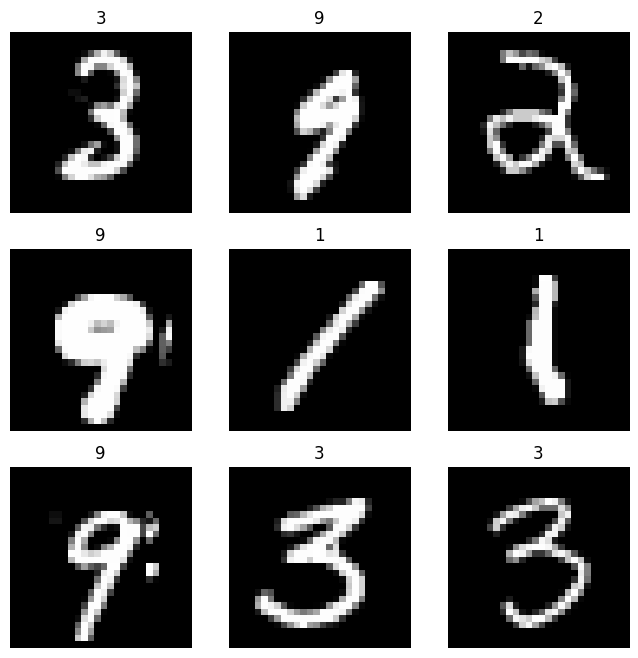

In [9]:
figure = plt.figure(figsize=(8,8))
rows, columns = 3, 3

for i in range(1, columns * rows + 1):
    sample_idx = torch.randint(len(data_mnist), size=(1,)).item()

    img, label = data_mnist[sample_idx]

    figure.add_subplot(rows, columns, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [10]:
print(f'Data type: {type(img)}')
print(f'Size: {img.shape}')
print(f'Min and Max img: {img.min()}, {img.max()}')
print(f'Category Type: {type(label)}')

Data type: <class 'torch.Tensor'>
Size: torch.Size([1, 28, 28])
Min and Max img: 0.0, 1.0
Category Type: <class 'int'>


In [11]:
torch.manual_seed(123)

In [12]:
train, val, test = torch.utils.data.random_split(
    data_mnist, [0.8, 0.1, 0.1]
)

print(f"Train size: {len(train)}")
print(f"Val size: {len(val)}")
print(f"test size: {len(test)}")

print(f"Train type: {type(train)}")
print(f"Val type: {type(val)}")
print(f"Test type: {type(train)}")

Train size: 48000
Val size: 6000
test size: 6000
Train type: <class 'torch.utils.data.dataset.Subset'>
Val type: <class 'torch.utils.data.dataset.Subset'>
Test type: <class 'torch.utils.data.dataset.Subset'>


In [13]:
from torch import nn

class NeuronalNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten() # image flatten
        self.net = nn.Sequential(
            nn.Linear(28*28, 15), # init step, hidden step
            nn.ReLU(), # ReLU function activation
            nn.Linear(15,10), # output step, no function activation 
        )

    def forward(self, x):
        x = self.flatten(x) # data flatten
        logits = self.net(x) # prediction

        return logits


In [14]:
model = NeuronalNetwork().to(device)
print(model)

NeuronalNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=784, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=10, bias=True)
  )
)


In [16]:
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters: ", total_params)

Total parameters:  11935


In [17]:
img, lbl = train[200]

print(type(img))
print(type(lbl))

<class 'torch.Tensor'>
<class 'int'>


In [18]:
lbl = torch.tensor(lbl).reshape(1)
print(type(lbl))

<class 'torch.Tensor'>


In [19]:
img, lbl = img.to(device), lbl.to(device)

In [20]:
logits = model(img)
print(logits)

tensor([[ 0.1762, -0.0300,  0.1198, -0.0336, -0.0994,  0.0021, -0.1259,  0.0016,
          0.0412,  0.1990]], grad_fn=<AddmmBackward0>)


Logits: tensor([[ 0.1762, -0.0300,  0.1198, -0.0336, -0.0994,  0.0021, -0.1259,  0.0016,
          0.0412,  0.1990]], grad_fn=<AddmmBackward0>)
Prediction: 9
Category: 6


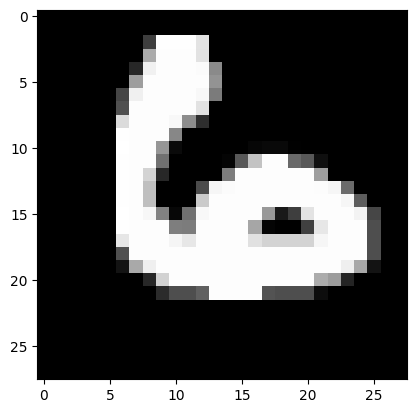

In [23]:
y_pred = logits.argmax(1)

plt.imshow(img.cpu().squeeze(), cmap="gray")

print(f"Logits: {logits}")
print(f"Prediction: {y_pred[0]}")
print(f"Category: {lbl[0]}")

In [24]:
fn_lost = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

In [25]:
loss = fn_lost(logits, lbl)
print(loss) # near to 0

tensor(2.4591, grad_fn=<NllLossBackward0>)


In [26]:
loss.backward()

In [28]:
optimizer.step() # update parameters
optimizer.zero_grad() # clear grad

# TRAINING

In [30]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1000

# training data
train_loader = DataLoader(
    dataset=train,
    batch_size=BATCH_SIZE,
    shuffle=True # random mix
)

# validation data
val_loader = DataLoader(
    dataset=val,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [31]:
LEARNING_RATE = 0.1
EPOCH = 10 # iteration

In [32]:
fn_lost = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [33]:
def train_loop(dataloader, model, loss_fn, optimizer):

    train_size = len(dataloader.dataset)
    nbatch = len(dataloader)

    model.train()

    lost_train, accuracy = 0, 0 # lost down, accuracy up to 100%

    for nlote, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)

        logits = model(X)

        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lost_train += loss.item()
        accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

        if nlote % 10 == 0:

            ndatos = nbatch*BATCH_SIZE

            print(f"Loss: {loss.item():>7f} [{ndatos:>5d}/{train_size:>5d}]")

    lost_train /= nbatch
    accuracy /= train_size

    print(f"Average accuracy:")
    print(f"Training: {(100*accuracy):>0.1f}% / {lost_train:>8f}")

In [34]:
def val_loop(dataloader, model, loss_fn):

    val_size = len(dataloader.dataset)
    nbatch = len(dataloader)

    model.eval()

    lost_val, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:

            X, y = X.to(device), y.to(device)

            logits = model(X)

            lost_val += loss_fn(logits, y).item()
            accuracy += (logits.argmax(1) == y).type(torch.float).sum().item()

    lost_val /= nbatch
    accuracy /= val_size

    print(f"Validation: {(100*accuracy):>0.1f}% / {lost_val:>8f} \n")

In [35]:
for t in range(EPOCH):
    print(f"Iteration: {t+1}/{EPOCH}\n--------------")

    train_loop(train_loader, model, fn_lost, optimizer)
    val_loop(val_loader, model, fn_lost)

print("The model was training!")

Iteration: 1/10
--------------
Loss: 2.460051 [48000/48000]
Loss: 2.174052 [48000/48000]
Loss: 1.985819 [48000/48000]
Loss: 1.811764 [48000/48000]
Loss: 1.597012 [48000/48000]
Average accuracy:
Training: 41.7% / 1.923168
Validation: 69.0% / 1.416131 

Iteration: 2/10
--------------
Loss: 1.395258 [48000/48000]
Loss: 1.185633 [48000/48000]
Loss: 1.008581 [48000/48000]
Loss: 0.908601 [48000/48000]
Loss: 0.766481 [48000/48000]
Average accuracy:
Training: 78.2% / 1.002708
Validation: 82.4% / 0.746401 

Iteration: 3/10
--------------
Loss: 0.718768 [48000/48000]
Loss: 0.684749 [48000/48000]
Loss: 0.651918 [48000/48000]
Loss: 0.565519 [48000/48000]
Loss: 0.558669 [48000/48000]
Average accuracy:
Training: 84.4% / 0.625960
Validation: 85.0% / 0.562420 

Iteration: 4/10
--------------
Loss: 0.547840 [48000/48000]
Loss: 0.489364 [48000/48000]
Loss: 0.480958 [48000/48000]
Loss: 0.498981 [48000/48000]
Loss: 0.489462 [48000/48000]
Average accuracy:
Training: 86.8% / 0.503834
Validation: 86.7% / 0.4

In [36]:
def predict(model, img):
    
    logits = model(img)
    y_pred = logits.argmax(1).item()

    plt.imshow(img.cpu().squeeze(), cmap="gray")
    plt.title(f"Category: {y_pred}")

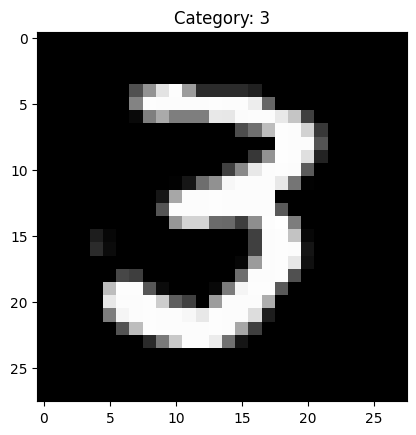

In [39]:
img, lbl = test[1234]

predict(model, img)